In [33]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import gzip
from itertools import islice
from collections import Counter

In [3]:
# stolen from https://gist.github.com/jakebiesinger/759018/1b7d6bd6967780a8bbae743760c37885bdf86467
def read_fastq(fastqfile, skip_blank=True):
    '''Parse a fastq-formatted file, yielding a (header, sequence, quality) tuple'''
    fastqiter = (l.strip('\n') for l in fastqfile)  # strip trailing newlines
    if skip_blank:
        fastqiter = filter(lambda l: l, fastqiter)  # skip blank lines
    while True:
        fqlines = list(islice(fastqiter, 4))
        if len(fqlines) == 4:
            header1, seq, header2, qual = fqlines
        elif len(fqlines) == 0:
            return
        else:
            raise EOFError("Failed to parse four lines from fastq file!")

        if header1.startswith('@') and header2.startswith('+'):
            yield header1, seq, qual
        else:
            raise ValueError("Invalid header lines: %s and %s for seq %s" % (header1, header2, seq))

In [29]:
COMP_TABLE = str.maketrans("ACTGN", "TGACN")

def revcomp(seq):
    '''Return the reverse complement of a DNA sequence'''
    if not set(seq).issubset({'A', 'C', 'G', 'T', 'N'}):
        raise ValueError(f"Sequence ({seq}) must only contain ACTGN")
    return seq.translate(COMP_TABLE)[::-1]

In [4]:
BC_DOWN = "TCTAGAGG"
PROBE_UP = "AGCAGGAGCCGCAGTG"
PROBE_DOWN = "CGTCAAGCGGCCAGTA"

Get all probe sequences

In [21]:
with open("../data/MPRA_Afib_SNPS_sequences_withprimers_Agilent_20230615.txt", 'rt') as f:
    probe_seqs = [l.strip() for l in f.readlines()][1:]
len(probe_seqs)

probe_bc_matches = {probe[24:-24]: {} for probe in probe_seqs}

In [30]:
failed = []
passed = 0
with gzip.open("../data/mpra-BC-mapping_R1_001.fastq.gz", 'rt') as f:
    for header, seq, qual in read_fastq(f):
        barcode = seq[:20]
        bc_downstream = seq[20:28]
        if bc_downstream != BC_DOWN:
            failed.append((header, seq, qual, "barcode downstream mismatch"))
            continue
        probe_start = seq.find(PROBE_UP) + len(PROBE_UP)
        probe_end = seq.find(PROBE_DOWN)
        if probe_start == -1 or probe_end == -1:
            failed.append((header, seq, qual, "probe up/down not found"))
            continue
        probe = revcomp(seq[probe_start:probe_end])
        if probe not in probe_bc_matches:
            failed.append((header, seq, qual, "probe not found in list"))
            continue
        passed += 1
        if barcode in probe_bc_matches[probe]:
            probe_bc_matches[probe][barcode] += 1
        else:
            probe_bc_matches[probe][barcode] = 1

In [34]:
failed_reason = [f[3] for f in failed]
print(Counter(failed_reason))

Counter({'probe not found in list': 50493, 'probe up/down not found': 37675, 'barcode downstream mismatch': 26716})


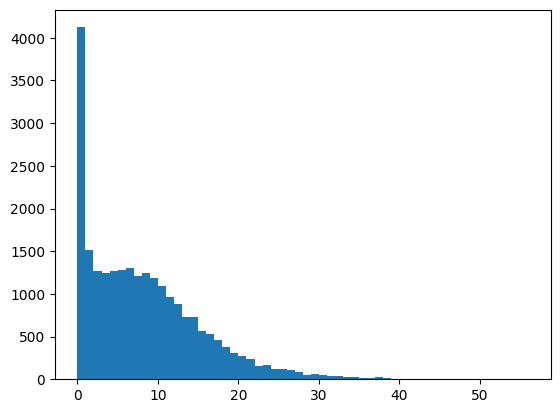

In [49]:
num_seqs = [sum(v.values()) for v in probe_bc_matches.values()]
plt.hist(num_seqs, bins=range(max(num_seqs)+1))
plt.show()

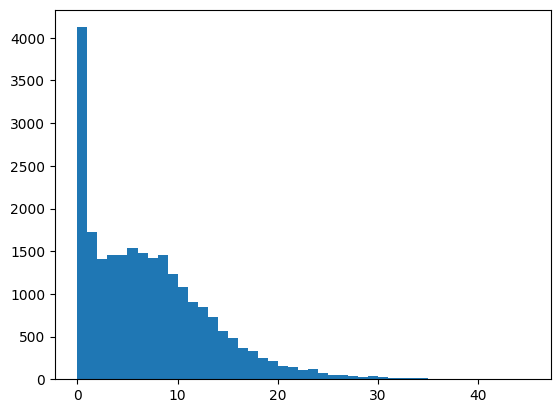

In [48]:
num_barcodes = [len(v) for v in probe_bc_matches.values()]
plt.hist(num_barcodes, bins=range(max(num_barcodes)+1))
plt.show()